# Sample Code

## 基礎建設

In [79]:
import pandas as pd
import gzip, json
import numpy as np
import re 
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

## 載入資料

In [10]:
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/All_Beauty.csv
!wget http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_All_Beauty.json.gz

'wget' ���O�����Υ~���R�O�B�i���檺�{���Χ妸�ɡC
'wget' ���O�����Υ~���R�O�B�i���檺�{���Χ妸�ɡC


In [169]:
metadata = getDF('../content/meta_All_Beauty.json.gz')
ratings = pd.read_csv('../content/All_Beauty.csv', names=['asin', 'reviewerID', 'overall', 'unixReviewTime'], header=None)

In [170]:
metadata.head()

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes
0,[],,[Loud 'N Clear Personal Sound Amplifier allows...,,Loud 'N Clear&trade; Personal Sound Amplifier,[],,idea village,[],"2,938,573 in Beauty & Personal Care (",[],{'ASIN: ': '6546546450'},All Beauty,,,,6546546450,[],[]
1,[],,[No7 Lift & Luminate Triple Action Serum 50ml ...,,No7 Lift &amp; Luminate Triple Action Serum 50...,"[B01E7LCSL6, B008X5RVME]",,,[],"872,854 in Beauty & Personal Care (",[],"{'Shipping Weight:': '0.3 ounces (', 'ASIN: ':...",All Beauty,"class=""a-bordered a-horizontal-stripes a-spa...",,$44.99,7178680776,[],[]
2,[],,[No7 Stay Perfect Foundation now stays perfect...,,No7 Stay Perfect Foundation Cool Vanilla by No7,[],,No7,[],"956,696 in Beauty & Personal Care (","[B01B8BR0O8, B01B8BR0NO, B014MHXXM8]","{'Shipping Weight:': '3.5 ounces (', 'ASIN: ':...",All Beauty,,,$28.76,7250468162,[],[]
3,[],,[],,Wella Koleston Perfect Hair Colour 44/44 Mediu...,[B0041PBXX8],,,[],"1,870,258 in Beauty & Personal Care (",[],"{' Item Weight: ': '1.76 ounces', 'Sh...",All Beauty,,,,7367905066,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
4,[],,[Lacto Calamine Skin Balance Daily Nourishing ...,,Lacto Calamine Skin Balance Oil control 120 ml...,[],,Pirmal Healthcare,[],"67,701 in Beauty & Personal Care (","[3254895630, B007VL1D9S, B00EH9A0RI, B0773MBG4...","{'Shipping Weight:': '12 ounces (', 'ASIN: ': ...",All Beauty,,,$12.15,7414204790,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...


In [171]:
ratings.head()

,asin,reviewerID,overall,unixReviewTime
0,0143026860,A1V6B6TNIC10QE,1.0,1424304000
1,0143026860,A2F5GHSXFQ0W6J,4.0,1418860800
2,0143026860,A1572GUYS7DGSR,4.0,1407628800
3,0143026860,A1PSGLFK1NSVO,5.0,1362960000
4,0143026860,A6IKXKZMTKGSC,5.0,1324771200


## 資料整理

In [172]:
ratings['DATE'] = pd.to_datetime(ratings['unixReviewTime'], unit='s')

## 資料切分

In [173]:
# Training date 
training_start_date = '2018-01-01'
training_end_date = '2018-09-01'
testing_end_date = '2018-09-30'

def split_data(training_end_date, testing_end_date, training_start_date = None):
    if training_start_date is None:
        ratings_trainings = ratings[
            (ratings['DATE'] < training_end_date)
        ]   
        ratings_testings = ratings[
            (ratings['DATE'] >= training_end_date) & 
            (ratings['DATE'] <= testing_end_date)
        ]
    else:
        ratings_trainings = ratings[
            (ratings['DATE'] >= training_start_date) & 
            (ratings['DATE'] < training_end_date)
        ]   
        ratings_testings = ratings[
            (ratings['DATE'] >= training_end_date) & 
            (ratings['DATE'] <= testing_end_date)
        ]
    
    ratings_testings_by_user = ratings_testings.groupby('reviewerID').agg(list).reset_index()[['reviewerID', 'asin']].to_dict('records')
    ratings_testings_by_user = { rating['reviewerID']: rating['asin'] for rating in ratings_testings_by_user }
    users = list(ratings_testings_by_user.keys())

    return ratings_trainings, ratings_testings, ratings_testings_by_user, users

ratings_trainings, ratings_testings, ratings_testings_by_user, users = split_data(training_end_date = training_start_date, testing_end_date = testing_end_date)


## 資料清洗

In [174]:
# 觀察資料型態 
# metadata.nunique(axis = 0, dropna = True) -> error, 因資料型態為list -> 強制轉str
print(metadata.astype(str).nunique())
# category/ fit/ tech2/ main_cat為空資料
# tech1/ date/ feture 資訊 or 重複資料量過多 
# 此次不使用圖片連結
# 篩選Content-Based 模型與 user profiling 可能使用到的欄位 與 刪除資料量過少/重複資料過多欄位
metadata = metadata[['asin', 'description', 'title', 'also_buy', 'brand', 'rank', 'also_view', 'price', 'details']]
metadata = metadata.drop_duplicates('asin')

category               1
tech1                 11
description        13751
fit                    1
title              32300
also_buy            6482
tech2                  1
brand               7863
feature              230
rank               31949
also_view           7894
details            32329
main_cat               1
similar_item        1301
date                  20
price               3530
asin               32488
imageURL           15737
imageURLHighRes    15737
dtype: int64


In [175]:
# Title 資料
print(len(metadata[metadata['title']== '']))
# 填補缺值
metadata['title'] = metadata['title'].apply(lambda x:x if x else 'no title')

# description 資料
print(len(metadata[metadata['description']== '']))
# 填補缺值
metadata['description'] = metadata['description'].apply(lambda x:x if x else 'no description')

1
0


0


no brand             15570
VAGA                   252
L'Oreal Paris          110
Betty Dain              82
Unknown                 79
EG GIFTS                79
b.m.c                   75
Gillette                73
Victoria's Secret       70
Bath & Body Works       69
Name: brand, dtype: int64

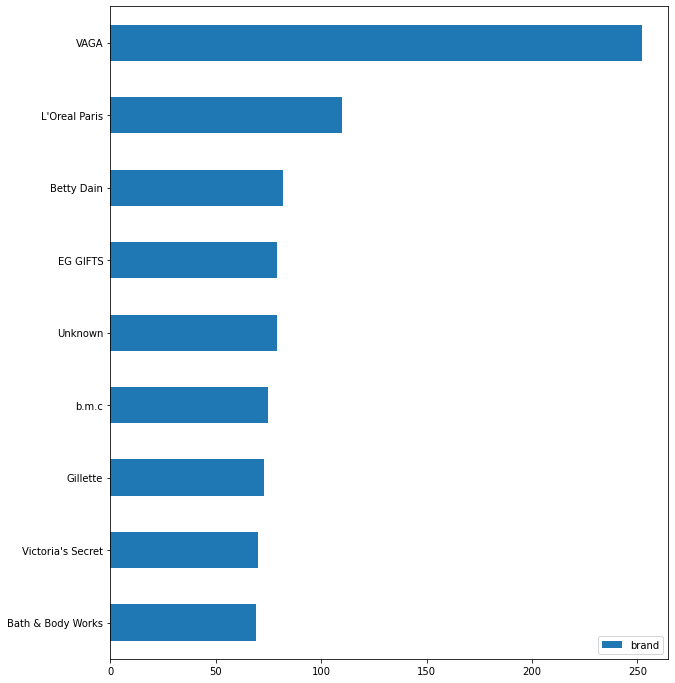

In [177]:
# 品牌資料
# 品牌空值資料數
print(len(metadata[metadata['brand']== '']))
# 填補缺值
metadata['brand'] = metadata['brand'].apply(lambda x:x if x else 'no brand')
metadata['brand'].value_counts(ascending=True).iloc[-10:-1].to_frame().plot(kind='barh',figsize=(10,12))
metadata['brand'].value_counts(ascending=False)[0:10]
# Unknown : 不確定是否為品牌 or 缺失資料 暫不處理

 Beauty  Personal Care       32015
 Grocery  Gourmet Food          37
 Health  Household              21
 Sports  Outdoors                3
 Toys  Games                     3
 Baby                            2
 Cloth                           2
 Home  Kitchen                   1
 Automotive                      1
 Tools  Home Improvement         1
Name: Sub_type, dtype: int64

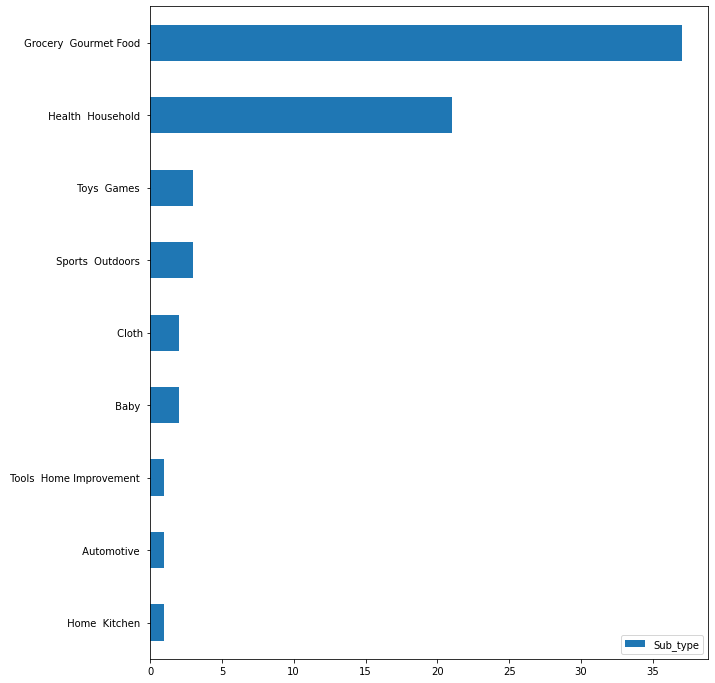

In [178]:
# rank 資料
metadata['Sub_type'] = metadata['rank'].str.split('in').str[1]
metadata['Sub_type'] = metadata['Sub_type'].str.replace(r'(','', regex=True)
metadata['Sub_type'] = metadata['Sub_type'].str.replace(r'&.*;','', regex=True)
metadata['Sub_type'] = metadata['Sub_type'].str.replace(r'&','', regex=True)
metadata['Sub_type'].value_counts(ascending=True).iloc[-10:-1].to_frame().plot(kind='barh',figsize=(10,12))
metadata['Sub_type'].value_counts()

In [179]:
# price 資料
# 價格正則
regex = re.compile(r'^\$[0-9]+\.[0-9]+$')
metadata.price.head(10)
# 空值/ , / .a-box-inner{background-color:#fff}#al...
metadata['price'] = metadata['price'].apply(lambda x:float(x.replace('$','').replace(',','')) if regex.match(x) else np.nan)

              price
count  11171.000000
mean      27.784923
std       47.212652
min        0.010000
25%        8.990000
50%       15.990000
75%       29.990000
max      999.990000


Text(0.5, 0, 'USD')

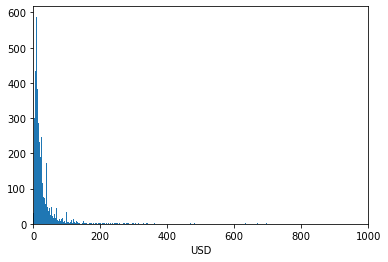

In [180]:
price = metadata.dropna(subset = ['price'])
print(price.describe())
plt.hist(metadata[metadata['price'] != '']['price'],bins=1000)
plt.xlim(0,1000)
plt.xlabel('USD')

In [181]:
# # 使用四分位數進行初步價格分類( & 無資料)
conditions = [
    np.isnan(metadata['price']),
    metadata['price'] <= 8.99,
    (metadata['price'] > 8.99) & (metadata['price'] <= 15.99),
    (metadata['price'] > 15.99) & (metadata['price'] <= 29.99),
    metadata['price'] > 29.99 
]

choices = ['no price', 'Q1', 'Q2', 'Q3', 'Q4']
metadata['price_category'] = np.select(conditions, choices)

## TF/IDF處理


In [182]:
# 計算商品用標題所表示的 tfidf 矩陣
# df = metadata.drop_duplicates('title')
# tf = TfidfVectorizer(analyzer='word')
# tfidf_matrix = tf.fit_transform(df['title'])

# 計算商品間的相似程度
# from sklearn.metrics.pairwise import cosine_similarity
# similarity_matrix = cosine_similarity(tfidf_matrix)
# mapping = pd.Series(df.index,index = df['title'])

# 每個商品回傳 k 個最相近的商品
def recommend_item(item_input, k=2):
    try:
        item_index = mapping[item_input]
        similarity_score = list(enumerate(similarity_matrix[item_index]))
        similarity_score = sorted(similarity_score, key=lambda x: x[1], reverse=True)
        similarity_score = similarity_score[:k]
        item_indices = [i[0] for i in similarity_score]
        return (df['asin'].iloc[item_indices].tolist())
    except:
        return []

# 利用使用者購買過的商品產生推薦
def recommend_items(items, k):
    res = []
    for d in items:
        res.extend(recommend_item(d, k))
    return res

In [183]:
# 合併 title/brand/Sub_type 同時提取特徵值
def concat(x):
    # 使用書名/ 簡介/ 價格分類/ 品牌合併文本
    words = f'{"".join(x["title"])}, {"".join((x["description"]))}, {"".join((x["price_category"]))}, {"".join((x["brand"]))} '
    words = re.sub(r'\,\(\)\&\;\,\.\/', "", words)
    words = words.lower()
    return words

In [184]:
metadata['feature'] = metadata.apply(concat, axis=1)
metadata['feature'].head()

0    loud 'n clear&trade; personal sound amplifier,...
1    no7 lift &amp; luminate triple action serum 50...
2    no7 stay perfect foundation cool vanilla by no...
3    wella koleston perfect hair colour 44/44 mediu...
4    lacto calamine skin balance oil control 120 ml...
Name: feature, dtype: object

In [143]:
# 計算tfidf矩陣
tf = TfidfVectorizer(min_df = 100)
tfidf_matrix = tf.fit_transform(metadata['feature'])
print(tfidf_matrix.shape)
# 計算商品相似度
similarity_matrix = cosine_similarity(tfidf_matrix)


(32488, 1616)


In [185]:
mapping = pd.Series(metadata.index,index = metadata['feature'])

In [186]:
# 每個商品回傳 k 個最相近的商品
def recommend_item(item_input, k=2):
    try:
        item_index = mapping[item_input]
        similarity_score = list(enumerate(similarity_matrix[item_index]))
        similarity_score = sorted(similarity_score, key=lambda x: x[1], reverse=True)
        similarity_score = similarity_score[:k]
        item_indices = [i[0] for i in similarity_score]
        return (metadata['asin'].iloc[item_indices].tolist())
    except:
        return []

# 利用使用者購買過的商品產生推薦
def recommend_items(items, k):
    res = []
    for d in items:
        res.extend(recommend_item(d, k))
    return res

recommend_item(metadata['feature'].loc[0], 2)
recommend_items([metadata['feature'].loc[0]], 2)
recommend_items(metadata[metadata['asin'].isin(ratings_trainings[ratings_trainings['reviewerID'] == users[0]]['asin'].tolist())]['feature'].tolist(), 10) 

[]

In [192]:
# also_buy
df_also_buy = metadata[['asin', 'also_buy']].apply(pd.Series.explode).reset_index(drop=True).dropna().value_counts().reset_index(name = 'also_buy_counts')
# also_review
df_also_view = metadata[['asin', 'also_view']].apply(pd.Series.explode).reset_index(drop=True).dropna().value_counts().reset_index(name = 'also_view_counts')

def rulebase_commander(training_data, user):
    global metadata, df_also_buy, df_also_view
    # metadata = metadata[['asin', 'also_buy', 'also_view']]
    # 先以Also_Buy 推薦 再以Also_Review推薦 若使用者為新客戶(先前無資料 則推薦最熱門的產品)
    # 針對metadata每個購買清單也會購買的產品排序
    #  # 前百大熱門產品
    popularity = training_data["asin"].value_counts().index.to_list()[0:100]
            # print(user)
    user_review = training_data[training_data['reviewerID'] == user]
    user_review_rank = user_review.groupby(['asin']).agg({'overall': 'mean'}).reset_index().sort_values(['overall'], ascending = False)
    # 1.篩選最喜好的產品top k 
    user_review_rank_max = user_review_rank[user_review_rank['overall'] >= user_review_rank.overall.max()]
    # 判斷是否有在熱門清單裡面 並重新推薦給客戶
    popularity_and_have_buy = [item for item in user_review_rank_max.asin if item in popularity][0:k]
    # popularity user_review_rank.asin
    # 2.篩選買過的產品 其他人 Also_buy 在熱門清單選項
    also_buy = df_also_buy[df_also_buy.asin.isin(user_review_rank.asin)]
    also_buy = [item for item in also_buy.also_buy if item in popularity]
    # 3.篩選買過的產品 其他人 Also_view 在熱門清單選項
    also_view = df_also_view[df_also_view.asin.isin(user_review_rank.asin)]
    also_view = [item for item in also_view.also_view if item in popularity]
    return also_buy, also_view, popularity_and_have_buy, popularity

also_buy, also_view, popularity_and_have_buy, popularity = rulebase_commander(ratings_trainings, users[0])


## 結果評估

In [193]:
def evaluate(ratings_testings_by_user={}, ratings_by_user={}, method=None):
    '''
    * ratings_testings_by_user: dict 真實被購買的商品資料（2018-09-01 以後資料）
    * ratings_by_user: dict 利用訓練資料學習的推薦商品
    * method: str
    * score: float
    '''
    total = 0
    for d in ratings_testings_by_user:
        if d in ratings_by_user:
            total += len(set(ratings_by_user[d]) & set(ratings_testings_by_user[d]))

    score = total / len(ratings_testings)
    return score


## 推薦系統測試 Content Base

In [198]:
user = "A012671347N9PAVZNSK8"
k = 5
# ratings_trainings
content_recommendations = recommend_items(metadata[metadata['asin'].isin(ratings_trainings[ratings_trainings['reviewerID'] == user]['asin'].tolist())]['feature'].tolist(), k) 
# profile filtering / rule based
also_buy, also_view, popularity_and_have_buy, popularity = rulebase_commander(ratings_trainings, user)
# type(content_recommendations)
user_recommendations = content_recommendations + popularity_and_have_buy + also_buy + also_view + popularity

In [199]:
def recommender(training_data, users=[], k=10):
    '''
    * training_data: dataframe 輸入的訓練資料集（2018-09-01 以前資料）
    * users: [] 需要被推薦的使用者
    * k: int 每個使用者需要推薦的商品數
    * recommendations: dict
      {
          使用者一： [推薦商品一, 推薦商品二, ...],
          使用者二： [...], ...
      }
    '''
    recommendations = {}

    for user in users:
        # print(user)
        # content-based
        # 若user曾在訓練期間內買過東西，就推薦過去買過的商品的相似商品給他們參考
        content_recommendations = recommend_items(metadata[metadata['asin'].isin(training_data[training_data['reviewerID'] == user]['asin'].tolist())]['feature'].tolist(), k) 
        # profile filtering / rule based
        also_buy, also_view, popularity_and_have_buy, popularity = rulebase_commander(training_data, user)
        # 整併所有推薦名單
        user_recommendations = content_recommendations + popularity_and_have_buy + also_buy + also_view + popularity
        # TOP K
        recommendations[user] = user_recommendations[0:k]
    return recommendations

### 推薦系統 評分

In [204]:
ratings_trainings, ratings_testings, ratings_testings_by_user, users = split_data(training_start_date = '2018-06-01', training_end_date = training_end_date, testing_end_date = testing_end_date)
ratings_by_user = recommender(ratings_trainings, users)
# method = evaluate(ratings_testings_by_user, ratings_by_user)
# print(f'Method Score: {method}')

In [205]:
method = evaluate(ratings_testings_by_user, ratings_by_user)
print(f'Method Score: {method}')

Method Score: 0.13389830508474576


In [206]:
ratings_trainings, ratings_testings, ratings_testings_by_user, users = split_data(training_end_date = training_end_date, testing_end_date = testing_end_date)
ratings_by_user = recommender(ratings_trainings, users)
method = evaluate(ratings_testings_by_user, ratings_by_user)
print(f'Method Score: {method}')

Method Score: 0.08305084745762711
